# Calculating data center emissions

**Table of contents**
- Overview
- Setup
  - Get Token
- Utility Functions
    - Function to call API
    - Input format for API
    - Accepted input values
- Use Case Implementation
  - Read Sample Data from the Data Center
  - Data Center Locations
  - Data Center Carbon Footprints - Location Based API
    - Data center - Location Based Carbon Footprints Distribution
    - Output Explanation
  - Data center Carbon Footprints - Market Based API
    - Data center - Market Based Carbon Footprints Distribution
    - Output Explanation
  - Comparison of Location and Market Carbon Intensity
- Related Links

## Overview

GHG Emission APIs that are used in this sample: **IBM Environmental Intelligence - Greenhouse Gas (GHG) Emissions - Location and Market APIs**

You can calculate Scope 2 emissions from data centers. The Location and Market APIs provide the necessary emission factors to automate the process of calculating greenhouse gas emissions associated with electricity, steam, heat, and cooling workloads.

**Business value**

By understanding these emissions, data center operators can assess their environmental impact for reporting, and identify opportunities for emission reduction.

**Use Case**

In this notebook, we will calculate Location and Market based carbon footprints for Data centers.



![datacenter_emission_capture.png](datacenter_emission_capture.png)

## Setup

Ensure that Python is installed in your system. Python 3+ is required.

<b>Note:</b> To run this notebook seamlessly, you must first configure your credentials for Location and Market APIs in a file named `secrets.ini` in the following format:

```
[EI]
api.api_key = <Your GHG APIs API key>
api.client_id = <Your GHG APIs client Id>

```

Keep the secrets.ini file at an appropriate relative location of this notebook, for example, as specified in this config:

```config.read('../../../auth/secrets.ini')```

In [155]:
# Install the packages below using pip/pip3 based on your python version.
#!pip install pandas configparser IPython plotly datetime kaleido
import pandas as pd
import configparser
import requests
import json
from IPython.display import display as display_summary
import plotly.express as px
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from datetime import datetime
import plotly.graph_objects as go

### Get token


Run the following code snippet to generate the Auth Bearer Token using your api_key configured in secrets.ini.

In [156]:
config = configparser.RawConfigParser()
config.read(['../../../auth/secrets.ini','../../../auth/config.ini'])

EI_API_KEY  = config.get('EI', 'api.api_key')
EI_CLIENT_ID = config.get('EI', 'api.client_id')
EI_AUTH_ENPOINT = config.get('EI', 'api.auth_endpoint')
EI_BASE_URL = config.get('EI', 'api.base_url')

def get_bearer_token(token):
    headers = {
        'Content-Type': 'application/json',
        'cache-control': 'no-cache',
    }
    data = {"apiKey":token, "clientId":EI_CLIENT_ID}
    bearer_token_req = requests.post(EI_AUTH_ENPOINT, headers=headers, data= json.dumps(data))
    if bearer_token_req.status_code != 200:
        print( "Error in getting Bearer token. Error code : ",bearer_token_req.status_code)
    return bearer_token_req.json()['access_token']

mybearer_token = get_bearer_token(EI_API_KEY)

## Utility Functions

### Function to call API

In [157]:
def Call_Carbon_API(CO2API, Co2Data, token):
    headers = {
        'accept': 'application/json',
        'Authorization': 'Bearer '+token,
        'Content-Type': 'application/json',
    }

    CO2response_req = requests.post( CO2API, headers=headers, data=json.dumps(Co2Data))
    if CO2response_req.status_code != 200:
        print( "Problem! Error in generating response. Error code : ",CO2response_req.status_code)
    return CO2response_req.json()


### Input format for API

In [158]:
def customer_id(customerid):
    Input =  {
              "id": customerid
          }
    return Input 

def customer_onBehalfOfClient(companyId,companyName):
    Input =  {
              "companyId": companyId,
              "companyName": companyName
          }
    return Input  


def customer_organisation(departmentId,departmentName):
    Input =  {
              "departmentId": departmentId,
              "departmentName": departmentName
          }
    return Input  


def customer_requestType(requestType):
    return requestType     


def customer_location(country,stateProvince,zipPostCode,city):
    Input =  {
              "country": country,
              "stateProvince": stateProvince,
              "zipPostCode": zipPostCode,
              "city": city
          }
    return Input        


def customer_site(siteId,siteName,buildingId,buildingName):
    Input = {
              "siteId": siteId,
              "siteName": siteName,
              "buildingId": buildingId,
              "buildingName": buildingName
          }               
    return Input

def location_input(commodity,energyConsumedMWh):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh
             }
    return input

def market_input(commodity,energyConsumedMWh,energySupplierResidualEF,supplierNameREC,energyPurchasedMWhREC,emissionFactorREC,
                sourceREC,expiryDateREC,instrumentTypeREC,trackingSystemREC,certificateNumberREC,supplierNameREDI,
                energyPurchasedMWhREDI,emissionFactorREDI,sourceREDI,expiryDateREDI,certificateNumberREDI,
                supplierNameDEPC,energyPurchasedMWhDEPC, suppliedEmissionFactorDEPC,expiryDateDEPC,certificateNumberDEPC):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh,
             "energySupplierResidualEF": energySupplierResidualEF,
             "supplierNameREC": supplierNameREC,
             "energyPurchasedMWhREC":energyPurchasedMWhREC,
             "emissionFactorREC":emissionFactorREC,
             "sourceREC": sourceREC,
             "expiryDateREC": expiryDateREC,
             "instrumentTypeREC": instrumentTypeREC,
             "trackingSystemREC": trackingSystemREC,
             "certificateNumberREC": certificateNumberREC,
             "supplierNameREDI": supplierNameREDI,
             "energyPurchasedMWhREDI": energyPurchasedMWhREDI,
             "emissionFactorREDI": emissionFactorREDI,
             "sourceREDI": sourceREDI,
             "expiryDateREDI": expiryDateREDI,
             "certificateNumberREDI": certificateNumberREDI,
             "supplierNameDEPC": supplierNameDEPC,
             "energyPurchasedMWhDEPC": energyPurchasedMWhDEPC,
             "suppliedEmissionFactorDEPC": suppliedEmissionFactorDEPC,
             "expiryDateDEPC": expiryDateDEPC,
             "certificateNumberDEPC": certificateNumberDEPC
  }
    return input

### Accepted input values



You can check the accepted values for the individual fields of the request payload. For more information, see the [Market section of the GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#market) and the [Location section of the GHG Emissions Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#location).


## Use Case Implementation

### Read Sample Data from the Data Center

In [159]:
df_asset = pd.read_csv("./datacenter_emission_capture.csv")
df_asset.head(5)

,Latitude,Longitude,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Commodity Usage,IT Load,PUE,Total Consumption,Renewable,Non-Renewable,Consumption Unit,Country,State,City,Zip Code,REDI Expiry Date,REDI Supplier Name,REDI Energy Source,REDI Certificate Number
0,40.7128,-74.0060,2022-01-01,2022-12-31,Electricity,70000,4.3,301000,60200,240800,MWh,USA,New York,New York,10001,2022-12-31,Bright Solar Solutions,Solar,RE12345
1,34.0522,-118.2437,2022-01-01,2022-12-31,Electricity,520300,3.5,1821050,0,1821050,MWh,USA,California,Los Angeles,90001,NaN,NaN,NaN,NaN
2,41.8781,-87.6298,2022-01-01,2022-12-31,Electricity,1200000,1.8,2160000,2160000,0,MWh,USA,Illinois,Chicago,60601,2022-12-31,SunRise Energy,Solar,RE12347
3,29.7604,-95.3698,2022-01-01,2022-12-31,Electricity,3000000,1.4,4200000,1806000,2394000,MWh,USA,Texas,Houston,77001,2022-12-31,GreenWind Energy,Wind,RE12348
4,33.4484,-112.0740,2022-01-01,2022-12-31,Electricity,800000,2.5,2000000,100000,1900000,MWh,USA,Arizona,Phoenix,85001,2022-12-31,SolarCity Renewables,Solar,RE12349


### Data Center Locations

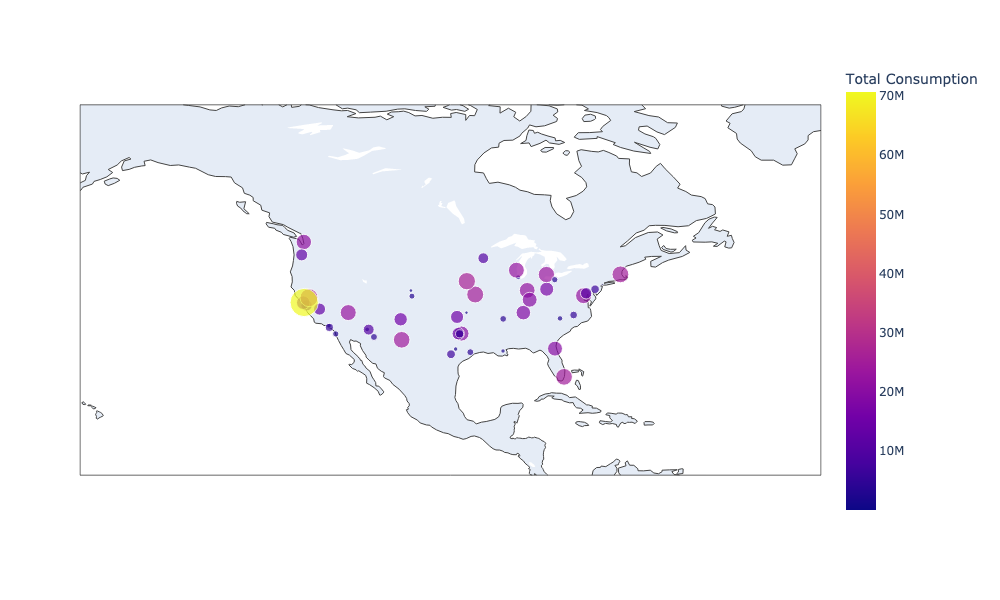

In [160]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="Total Consumption",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

### Data Center Carbon Footprints - Location Based API

Calculating data center carbon footprints based on the location.

In [161]:
EI_location_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/location"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=str(row['Zip Code']),
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData' : location_input(commodity=row['Commodity Usage'],
                                                        energyConsumedMWh=str(row['Total Consumption']))
                    }        
    CO2Response = Call_Carbon_API(EI_location_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_location_res = pd.json_normalize(CO2Response_list)
df_asset ['loc_CO2e'] = df_location_res['CO2e (metric tonne)']

#### Data center - Location Based Carbon Footprints Distribution

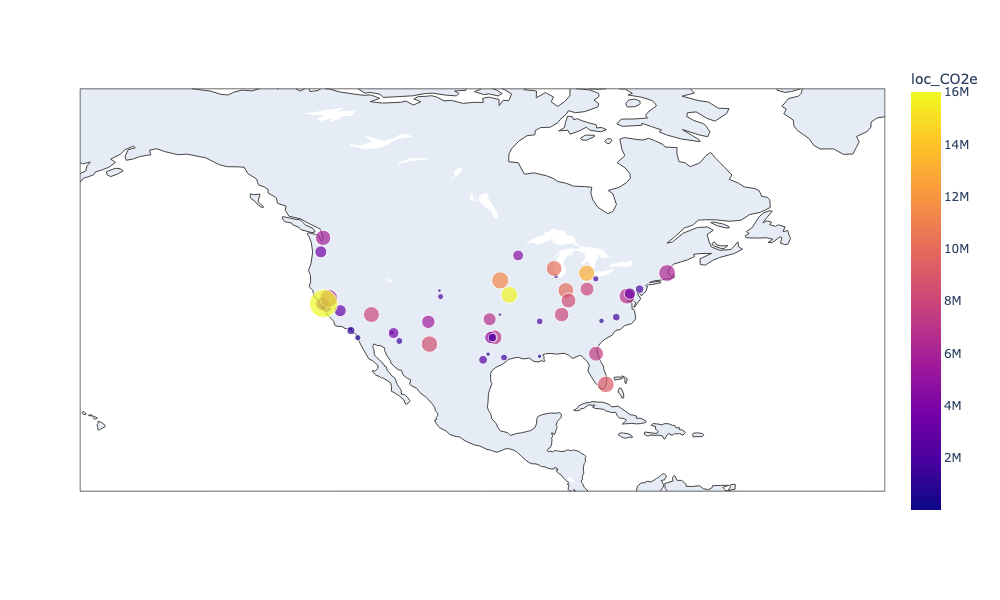

In [162]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="loc_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

#### Output Explanation



<b>CO2e (metric tonne)</b> -             The total amount of greenhouse gases emitted in metric tonnes


### Data center Carbon Footprints - Market Based API

Calculating data center carbon footprints based on the market.

In [166]:
# function to convert date to "%m-%d-%Y" format if not 'nan'
def convert_date(date_string):
    if pd.notna(date_string):
        date_object = datetime.strptime(date_string, "%Y-%m-%d")
        return date_object.strftime("%m-%d-%Y")
    else:
        return date_string  # Return 'nan' or whatever value it is

# function to return 'na' if not 'nan' (not a valid value)
def check_nan(value):
    if pd.notna(value):
        return value
    else:
        return 'na'

def check_zero(value):
    if pd.notna(value):
        return value
    else:
        return '0'
    
EI_market_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/market"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=str(row['Zip Code']),
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData'   :  market_input(commodity=row['Commodity Usage'],
                                                    energyConsumedMWh=str(row['Total Consumption']),
                                                    energySupplierResidualEF='na',
                                                    supplierNameREC='na',
                                                    energyPurchasedMWhREC='0',
                                                    emissionFactorREC='0',
                                                    sourceREC='na',
                                                    expiryDateREC='na',
                                                    instrumentTypeREC='na',
                                                    trackingSystemREC='na',
                                                    certificateNumberREC='0',
                                                    supplierNameREDI=str(check_nan(row['REDI Supplier Name'])),
                                                    energyPurchasedMWhREDI=str(check_zero(row['Renewable'])),
                                                    emissionFactorREDI='0',
                                                    sourceREDI=str(row['REDI Energy Source']),
                                                    expiryDateREDI=check_nan(convert_date(row['REDI Expiry Date'])),
                                                    certificateNumberREDI=str(check_zero(row['REDI Certificate Number'])),
                                                    supplierNameDEPC='na',
                                                    energyPurchasedMWhDEPC='0', 
                                                    suppliedEmissionFactorDEPC='0',
                                                    expiryDateDEPC='na',
                                                    certificateNumberDEPC='0')
                    }       
    CO2Response = Call_Carbon_API(EI_market_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_market_res = pd.json_normalize(CO2Response_list)
df_asset ['market_CO2e'] = df_market_res['CO2e (metric tonne)']

#### Data center - Market Based Carbon Footprints Distribution

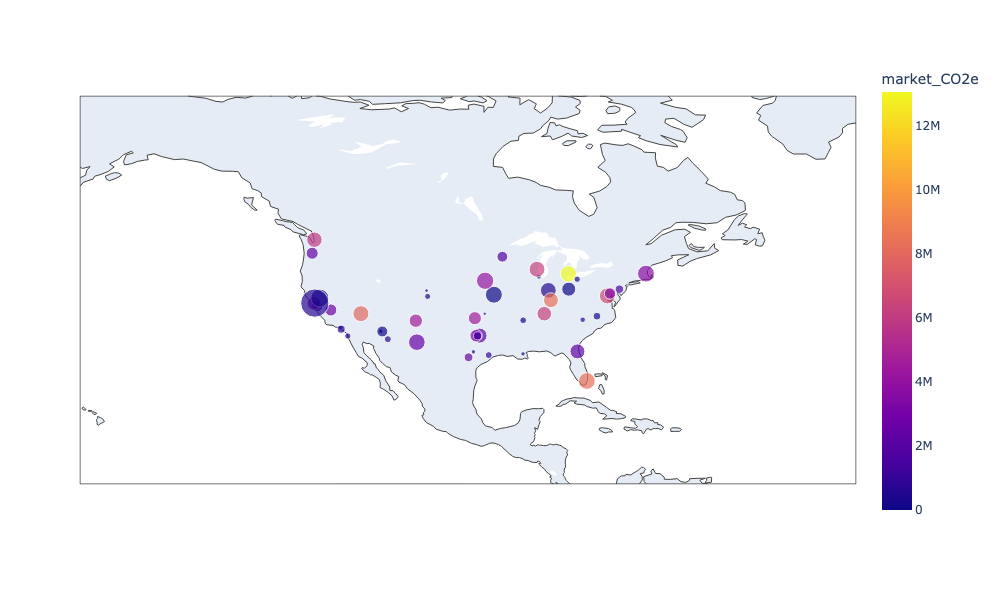

In [164]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="market_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more),
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

#### Output Explanation



<b>CO2e (metric tonne)</b> -           The total amount of greenhouse gases emitted in metric tonnes


### Comparison of Location and Market Carbon Intensity

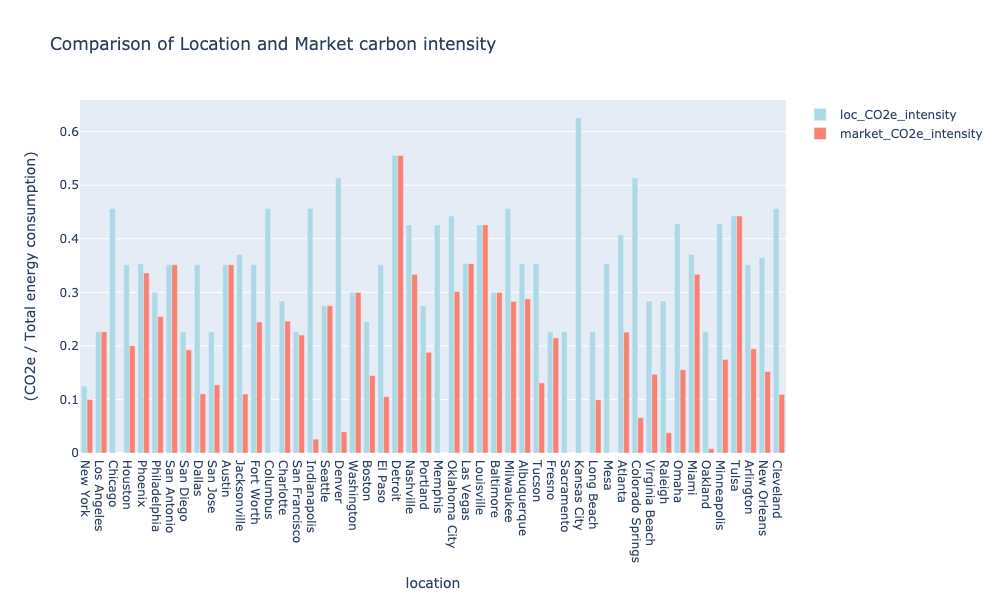

In [165]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['loc_CO2e']/df_asset['Total Consumption'], name='loc_CO2e_intensity', marker_color='lightblue'))
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['market_CO2e']/df_asset['Total Consumption'], name='market_CO2e_intensity', marker_color='salmon'))
fig.update_layout(
    title='Comparison of Location and Market carbon intensity ',
    xaxis_title='location',
    yaxis_title='(CO2e / Total energy consumption)',
    barmode='group',
    width=1000, 
    height=600 
)
fig.show("png")

Here, we see the carbon emission intensity of the location and market based methods across 50 sample data centers. The location based emission considers only the average grid emission factor. The market based method also considers the purchase of renewables in accordance with GHG protocol. The variation in market based carbon intensity compared to location based across different locations shows the extra effort made by the enterprises to reduce the carbon footprints by the purchase of renewables. The organization can decide to further reduce their carbon footprints based on the market based carbon intensity.

## Related Links

[GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API)